<a href="https://colab.research.google.com/github/raktim-roychoudhury/dl_sp500_prediction/blob/main/HW3_Raktim_rr4081.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3  
\# Raktim Roychoudhury
\# rr4081


* The main goal of assignment 3 is to develop a **deep learning classification** model to predict the direction of the S&P500 (daily basis) for the dates **2022-01-01—2022-11-30** (test set). The period of the train dataset is your own choice (normally it should be more than 15 years). You may consider dividing the dataset and shifting the training window after each prediction on a quarterly, monthly or weekly basis, but any type of processing will be accepted as long as it makes sense.
* Make sure that you switch your GPU on, you have access to it on Colab. The training stage may take long, you might want to use a smaller amount of data, or fewer epochs at first to speed up your development process.  
*   Note that we *won't* be attempting to measure the quality of every feature (i.e., how much it improves the model), so please don't be afraid if your model doesn't output good results.  
* **Hand in**: Please submit the .ipynb notebook and name it ‘HWX_FirstName_NetID’. The notebook should include all classes and functions you implemented with proper comments, and explanation of your operations and results. 

In [186]:
pip install yfinance --upgrade --no-cache-dir #installing yahoofinance api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [187]:
import pandas as pd
import numpy as np
import keras
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns

#1. Import the Dataset (2pts) 
You may use [yfinance](https://pypi.org/project/yfinance/) API to prepare the data. A typical historical dataset contains the date, open price, close price, highest price, lowest price, and volume of the asset for each trading day. Download the historical dataset for S\&P500 and conduct necessary data pre-processing.


In [188]:
# download the data
ticker = yf.Ticker('^GSPC') # ticker symbol for S&P500
sp500_rawdata = ticker.history(period = '15y')
sp500_rawdata.to_csv('sp500_raw.csv')
## Your code here!

In [189]:
#loading data into dataframe and formatting
sp500_rawdata = pd.read_csv('sp500_raw.csv', parse_dates = ['Date'])
sp500_rawdata.index = sp500_rawdata['Date'].apply(lambda x : x.strftime('%m-%d-%Y'))
sp500_rawdata.drop(['Date','Dividends','Stock Splits'], axis = 1, inplace = True)
sp500_rawdata.head()

,Open,High,Low,Close,Volume
Date,,,,,
12-10-2007,1505.109985,1518.270020,1504.959961,1515.959961,2911760000
12-11-2007,1516.680054,1523.569946,1475.989990,1477.650024,4080180000
12-12-2007,1487.579956,1511.959961,1468.229980,1486.589966,4482120000
12-13-2007,1483.270020,1489.400024,1469.209961,1488.410034,3635170000
12-14-2007,1486.189941,1486.670044,1467.780029,1467.949951,3401050000


In [190]:
sp500_rawdata.describe()

,Open,High,Low,Close,Volume
count,3776.000000,3776.000000,3776.000000,3776.000000,3.776000e+03
mean,2215.097594,2227.988289,2201.043308,2215.374645,4.114588e+09
std,1022.108131,1027.424775,1016.318203,1022.129887,1.144720e+09
min,679.280029,695.270020,666.789978,676.530029,1.025000e+09
25%,1336.987518,1344.794952,1329.184967,1336.842529,3.392098e+09
50%,2045.114990,2056.380005,2035.505005,2045.570007,3.860325e+09
75%,2830.357544,2844.404968,2815.505066,2832.947449,4.577818e+09
max,4804.509766,4818.620117,4780.040039,4796.560059,1.145623e+10


#2. Feature Engineering (2pts) 
* For this part, you can choose and compute any feature you like (most features work in deep learning models as long as they are normalized).  

* Do not include data that is not published or can't be accessed on the predicting date, this will bring information leakage problems.  

* Split the data into train and test set.

In [191]:
## Your code here!
def AddFeatures(data):
  classify = lambda x : 1 if x > 0 else 0
  data['Daily_Return'] = (data['Close']-data['Open'])/data['Open'] #calculate daily return
  data['5D_MA_Return'] = data['Daily_Return'].rolling(5, min_periods = 5).mean() #calculate 5 day moving average Returns
  data['5D_MA_Volume'] = data['Volume'].rolling(5, min_periods = 5).mean() #calculate 5 day moving average volume
  data['Target'] = data['Daily_Return'].apply(classify).shift(-1) #1 is positive returns, 0 if negative returns, for next day
  data.dropna(inplace = True) #dropping NA values
  data.drop(data.tail(1).index,inplace=True) #dropping last row, since target values are next day's return
  return data

In [192]:
sp500 = AddFeatures(sp500_rawdata)
sp500

,Open,High,Low,Close,Volume,Daily_Return,5D_MA_Return,5D_MA_Volume,Target
Date,,,,,,,,,
12-14-2007,1486.189941,1486.670044,1467.780029,1467.949951,3401050000,-0.012273,-0.005600,3.702056e+09,0.0
12-17-2007,1465.050049,1465.050049,1445.430054,1445.900024,3569030000,-0.013071,-0.009656,3.833510e+09,1.0
12-18-2007,1445.920044,1460.160034,1435.650024,1454.979980,3723690000,0.006266,-0.003256,3.762212e+09,0.0
12-19-2007,1454.699951,1464.420044,1445.310059,1453.000000,3401300000,-0.001169,-0.003356,3.546048e+09,1.0
12-20-2007,1456.420044,1461.530029,1447.219971,1460.119995,3526890000,0.002540,-0.003541,3.524392e+09,1.0
...,...,...,...,...,...,...,...,...,...
11-29-2022,3964.189941,3976.770020,3937.649902,3957.629883,3546040000,-0.001655,0.001007,3.207128e+09,1.0
11-30-2022,3957.179932,4080.110107,3938.580078,4080.110107,6579360000,0.031065,0.005300,3.745402e+09,0.0
12-01-2022,4087.139893,4100.509766,4050.870117,4076.570068,4527130000,-0.002586,0.003435,3.994884e+09,1.0


In [193]:
#checking for class imbalance
class1 = sp500['Target'].sum()
class0 = len(sp500) - class1
class1_pct = class1/(class1 + class0)
class0_pct = 1 - class1_pct
print(f'Percentage of class 0 target values : {class0_pct}')
print(f'Percentage of class 1 target values : {class1_pct}')

Percentage of class 0 target values : 0.4602122015915119
Percentage of class 1 target values : 0.5397877984084881


#3. Deep Learning Binary Classification (6 pts)

* Either [Pytorch](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or [Tensorflow](https://www.tensorflow.org/tutorials/quickstart/beginner) is allowed to use.
* You can choose any type of deep learning architecture, e.g., LSTM, GRU, CNN, it is up to you.  
* You can implement an option to save your model after training, but this is optional. Print the ROC(AUC) and the train loss as well as the test loss. And plot scores vs. training epochs with 4 curves. 
* Remember to **set the random seed** (random state) so that when we run your software, we get similar results (the results doesn't have to be exactely the same). 
* **Extra credit**: Exceptional work will receive up to 2 bonus points, e.g. preventing overfitting by setting early stop, performing hyperparameters tuning, conducting validation test, etc.    
* And lastly, remember this is the stock market, so it is **difficult** to have an accuracy above 50%, and you won't be deducted any point for bad prediction results, good luck!

In [217]:
## Your code here!
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation
from keras.optimizers import Adam

In [195]:
#splitting the data into batches of appropriate dimensions
def split_sequences(inputs, outputs, n_timesteps):
    X, y = list(), list()
    for i in range(len(inputs)):
        # find the end of this pattern
        end_ix = i + n_timesteps
        # check if we are beyond the dataset
        if end_ix > len(inputs):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = inputs.iloc[i:end_ix, :], outputs.iloc[end_ix-1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [196]:
#splitting the data into train test sets and scaling the features.
def ProcessData(data, test_size, scaler): 
  X, y = data.iloc[:,:-1], data.iloc[:,-1]
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = 42)
  scaler_obj = scaler()
  scaler_obj.fit_transform(X_train)#using training parameters for test set to avoid foresight leakage
  scaler_obj.transform(X_test)
  return X_train, X_test, y_train, y_test

In [197]:
X_train, X_test, y_train, y_test = ProcessData(sp500, 0.05, StandardScaler) #95% training set, 5% test set

In [198]:
def model_fit(inputs,outputs,config):
  # model configuration
  n_timesteps, n_nodes, n_epochs, n_batch = config
     
  # converting into batches
  X_train, y_train = split_sequences(inputs, outputs, n_timesteps) #constructs histories of length timesteps
    
  # flatten the CUBE X_train because the fit function must be fed by a MATRIX 
  n_input = X_train.shape[1] * X_train.shape[2]
  X_train = X_train.reshape((X_train.shape[0], n_input))

  # model
  activation = 'tanh'
  final_activation = 'sigmoid'
  model = Sequential()
  model.add(Dense(n_nodes, activation=activation, input_dim=n_input, name = 'hidden_layer_1'))
  model.add(Dense(n_nodes + 3, activation = activation, name = 'hidden_layer_2'))
  model.add(Dense(n_nodes - 2, activation = activation, name = 'hidden_layer_3'))
  model.add(Dense(1, activation = final_activation, name = 'hidden_layer_4'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
  # fit model
  hist = model.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batch, shuffle=False, verbose=0, validation_split = 0.05) #5% validation set
  return hist, model

In [199]:
#plotting training and validation accuracy v/s epochs
def plotTraining(model):
  %matplotlib inline
  sns.set()

  acc = model.history['accuracy']
  val = model.history['val_accuracy']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize = (12,5)) 
  plt.plot(epochs, acc, '-', label='Training accuracy')
  plt.plot(epochs, val, ':', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.plot()

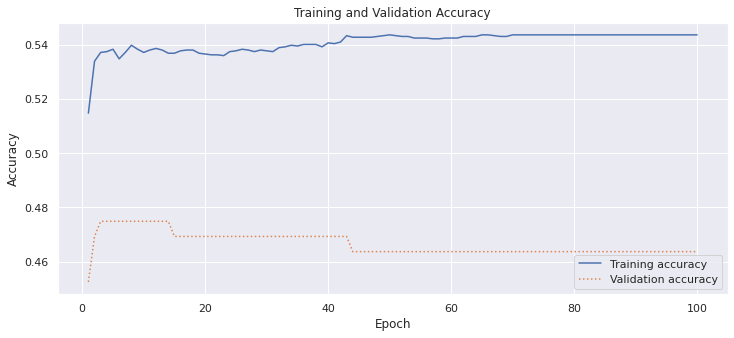

In [200]:
config = [5, len(X_train.columns), 100, 5] #timesteps = 5, no. of features = 8, epochs = 100, batches = 5
hist, model = model_fit(X_train, y_train, config)
plotTraining(hist)

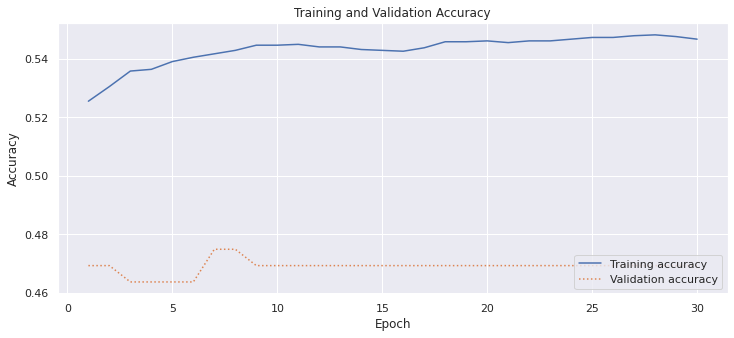

In [201]:
config = [10, len(X_train.columns), 30, 5] #timesteps = 10, no. of features = 8, epochs = 30, batches = 5
hist, model = model_fit(X_train, y_train, config)
plotTraining(hist)

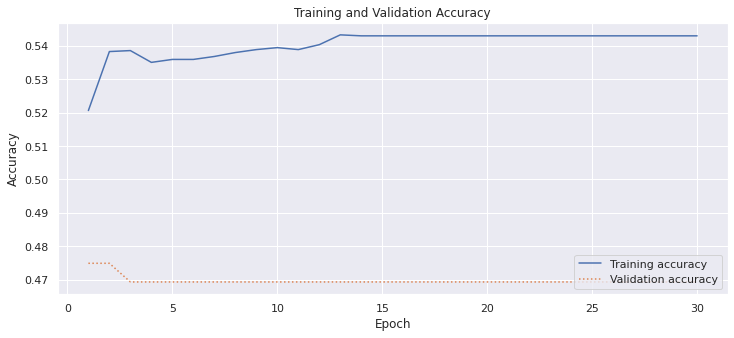

In [212]:
config = [5, len(X_train.columns), 30, 5] #timesteps = 5, no. of features = 8, epochs = 30, batches = 5
hist, model = model_fit(X_train, y_train, config)
plotTraining(hist)

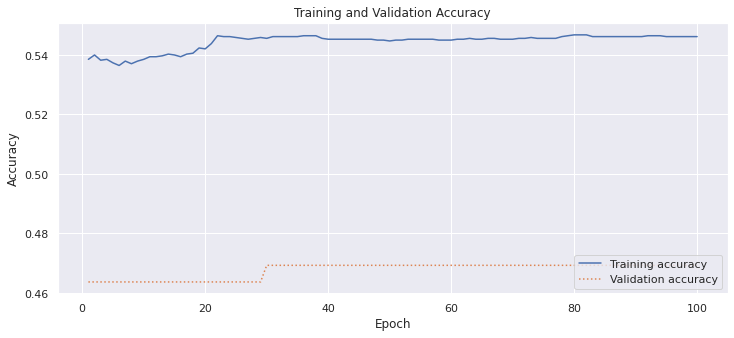

In [208]:
config = [3, len(X_train.columns), 100, 8] #timesteps = 3, no. of features = 8, epochs = 100, batches = 8
hist, model = model_fit(X_train, y_train, config)
plotTraining(hist)
#based on the different model hyperparameters we tested above, we decide to use the previous model hyperparameters given the best performance seen in the graph above

In [213]:
def model_predict(model, X_input): #timesteps = 3, no. of features = 8, epochs = 100, batches = 8
  #X_input is a MATRIX
	n_timesteps = X_input.shape[0] #should be the same as n_timesteps from config
	n_features = X_input.shape[1] * X_input.shape[2]

  #reshape the MATRIX X_input because the predict function must be fed by a VECTOR 
	X_array = X_input.reshape((X_input.shape[0], X_input.shape[1] * X_input.shape[2]))
    
	# predict
	yhat = model.predict(X_array, verbose=0)

	return yhat

In [215]:
X_test_arr, y_test_arr = split_sequences(X_test, y_test, 5) #generating test data batches
y_predicted = model_predict(model, X_test_arr).squeeze()
y_predicted = (y_predicted > 0.5).astype(int) #converting probabilities to binary values

In [218]:
print(f'Accuracy score : {accuracy_score(y_predicted, y_test_arr)*100:.2f}%')
print(f'Precision score : {precision_score(y_predicted, y_test_arr)*100:.2f}%')
print(f'Recall score : {recall_score(y_predicted, y_test_arr)*100:.2f}%')
print(f'F1 score : {f1_score(y_predicted, y_test_arr)*100:.2f}%')

Accuracy score : 55.68%
Precision score : 100.00%
Recall score : 55.68%
F1 score : 71.53%


We observe that although the DL algorithm works well with >50% accuracy,we must note that there is a bull market bias in the test set and we need to further analyze its performance on different markets conditions as well.